In [ ]:
# default_exp data_processing
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import FRED
if torch.__version__[:4] == '1.13': # If using pytorch with MPS, use Apple silicon GPU acceleration
    # device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.has_mps else "cpu")
    # no one needs to do dataset stuff on CPU
    device = torch.device('cpu')
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)
%load_ext autoreload
%autoreload 2

Using device cpu


# 02d Flow Datasets
> Here be the tailored datasets for FRED! In addition to storing points, we must store a graph, and intelligently sample from the graph so that batches preserve 'flow neighborhoods'

As previously listed, this is our preprocessing pipeline.

0. Turn data to torch tensors
1. Build graph from data, using flashlight kernel
	1. Estimate best parameters for kernel selection
2. Take diffusion map on data (or any ‘best guess embedding’) we want to penalize against. (Can be done on CPU or GPU). Would likely use established methods, like PHATE, tSNE, node2vec.
	1. Visualize embedding
3. Find flow neighborhoods of data (possibly at multiple scales)
4. **Break data into batches (both affinity matrix of batches and points in batches).**
5. **Return `Dataloader` with minibatch `X` and subgraph `A` of each batch.**


0-3 are handled by separate functions. This notebook calls upon these functions, and implements the machinery for 4 and 5

# Two Types of Data
FRED can operate on both directed graphs (assumed to be sampled from a manifold with flow, ala the "Manifold with Flow" hypothesis) and pointclouds with associated velocity vectors (like RNA velocity single cell data). Each type is processed differently, and requires a different dataset class.

In [ ]:
# export
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
import torch.nn.functional as F
from FRED.data_processing import flashlight_affinity_matrix, diffusion_map_from_affinities, flow_neighbors
class ManifoldWithVectorField(Dataset):
    """
    Dataset object to be used with FRED for pointcloud and velocity input data.
    Takes np.arrays for X (points) and velocities (velocity vectors per point).
    For each item retrieved, returns a neighborhood around that point (based on local euclidean neighbors) containing local affinities

    """
    def __init__(self, X, velocities, labels, sigma="automatic", flow_strength = 1, prior_embedding = "diffusion map", t_dmap = 1, dmap_coords_to_use = 2, n_neighbors = 5, minibatch_size = 100, nbhd_strategy = "flow neighbors", verbose = False):
        # Step 0: Convert data into tensors
        self.X = torch.tensor(X).float()
        self.velocities = torch.tensor(velocities).float()
        self.labels = labels
        self.n_neighbors = n_neighbors
        self.nbhd_strategy = nbhd_strategy
        self.n_nodes = self.X.shape[0]
        self.minibatch_size = minibatch_size
        
        # Step 1. Build graph on input data, using flashlight kernel
        if verbose: print("Building flow affinitiy matrix")
        self.A = flashlight_affinity_matrix(self.X, self.velocities, sigma = sigma, flow_strength = flow_strength)
        self.P_graph = F.normalize(self.A, p=1, dim=1)
        # visualize affinity matrix
        plt.imshow(self.A.numpy())

        # Step 2. Take a diffusion map of the data
        # These will become our 'precomputed distances' which we use to regularize the embedding
        if prior_embedding == "diffusion map":
            self.P_graph_symmetrized = self.P_graph + self.P_graph.T
            diff_map = diffusion_map_from_affinities(
                self.P_graph_symmetrized, t=t_dmap, plot_evals=False
            )
            self.diff_coords = diff_map[:, :dmap_coords_to_use]
            self.diff_coords = self.diff_coords.real
            self.diff_coords = torch.tensor(self.diff_coords.copy()).float()
            self.precomputed_distances = torch.cdist(self.diff_coords, self.diff_coords)
            # scale distances between 0 and 1
            self.precomputed_distances = 2 * (
                self.precomputed_distances / torch.max(self.precomputed_distances)
            )
            self.precomputed_distances = (
                self.precomputed_distances.detach()
            )  # no need to have gradients from this operation
        # Step 3: This returns a sparse representation of the flow neighborhoods, in the form of two tensors: row, col. The numbers in row specify the index, and the adjacent entries in col are the neighbors of that index.
        if nbhd_strategy == "flow neighbors":
            self.neighborhoods = flow_neighbors(self.n_nodes, self.P_graph, self.n_neighbors)
        if nbhd_strategy == "euclidean neighbors":
            # Get points with nearest diffusion distances, based on above computation with dmap on symmetrized
            # directed diffusion matrix
            Neighbors = NearestNeighbors(n_neighbors=self.n_neighbors).fit(self.X)
            dists, indxs = Neighbors.kneighbors()
            self.neighborhoods = torch.tensor(indxs)
    def neighbors_from_point(self, idx):
        if self.nbhd_strategy == "flow neighbors":
            # Returns list of idxs of neighbors of the given idx
            row, col = self.neighborhoods
            idxs = torch.squeeze(torch.nonzero(row == idx))
            return col[idxs]
        elif self.nbhd_strategy == "euclidean neighbors":
            return self.neighborhoods[idx]

    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        # Get the neighborhood around the central point
        nbhd_idxs = self.neighbors_from_point(idx)
        # And sample random points -- for negative sampling loss
        random_idxs = torch.tensor(np.random.choice(np.arange(self.n_nodes), size=(self.minibatch_size))).long()
        minibatch_idxs = torch.concat([torch.tensor([idx]), nbhd_idxs, random_idxs])
        # Compute miniature diffusion matrix
        A_batch = self.A[minibatch_idxs][:,minibatch_idxs]
        P_batch = F.normalize(A_batch, p=1, dim=1)
        # Get actual points
        X_batch = self.X[minibatch_idxs]
        # Get subset of distances
        mini_precomputed_distances = self.precomputed_distances[minibatch_idxs][:,minibatch_idxs]
        # compute sparse representation of neighborhood around idx
        row = torch.zeros(self.n_neighbors).long()
        col = torch.arange(1,self.n_neighbors+1).long()
        neighbors = torch.vstack(
            [row, col]
        )
        # Embed these into a dictionary for easy cross reference
        return_dict = {
            "P":P_batch,
            "X":X_batch,
            "num flow neighbors":self.n_neighbors,
            "precomputed distances": mini_precomputed_distances,
            "neighbors":neighbors,
            "labels":self.labels[minibatch_idxs],
        }
        return return_dict
    def all_data(self):
        return_dict = {
            "P":self.P_graph,
            "X":self.X,
            "num flow neighbors":self.n_neighbors,
            "precomputed distances":self.precomputed_distances,
            "neighbors": self.neighborhood,
        }
        return return_dict

## Testing

In [ ]:
from FRED.datasets import directed_swiss_roll_delayed
X, flow, labels = directed_swiss_roll_delayed(num_nodes=1000)

Set sigma =  2.3770864


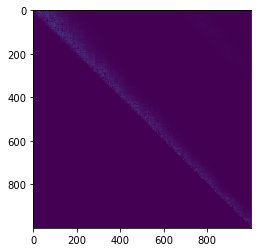

In [ ]:
ds = ManifoldWithVectorField(X, flow, labels)

In [ ]:
for data in ds:
    print(data)

{'P': tensor([[4.0173e-02, 2.0302e-01, 1.4001e-01,  ..., 3.0227e-06, 7.4944e-05,
         9.0509e-05],
        [5.7301e-03, 4.8314e-02, 1.7639e-01,  ..., 3.6155e-06, 1.1521e-04,
         1.3691e-04],
        [3.7528e-03, 5.3394e-03, 5.2184e-02,  ..., 5.4380e-06, 2.1628e-04,
         2.7195e-04],
        ...,
        [4.0596e-05, 3.4174e-05, 3.4960e-05,  ..., 5.3405e-01, 4.7545e-05,
         5.5604e-05],
        [9.8737e-07, 9.0580e-07, 8.7754e-07,  ..., 1.1897e-05, 4.3833e-03,
         1.0262e-05],
        [6.1747e-06, 5.9572e-06, 6.7358e-06,  ..., 3.8245e-04, 1.7551e-01,
         3.5869e-02]]), 'X': tensor([[  0.1206,  -4.7363,   8.7103],
        [  0.6952,  -4.8060,   8.8976],
        [  1.7228,  -4.7575,   8.3396],
        [  0.9074,  -4.8139,   8.1674],
        [  2.1120,  -4.6818,   8.6144],
        [  2.1504,  -4.6726,   8.7908],
        [ -8.0750,  -6.0072,  -5.8267],
        [ -6.4002,  -8.1048,  -0.9108],
        [ -0.0410,   7.8591,   9.3457],
        [ -9.4748,  -0.7765,  -5

# Dataloaders
Because we're handling batching in a, sahll we say, delicate way, the standard way of batching data doesn't work (without some downstream effort). In fact, we're treating each output element of the dataset as a batch by itself, so we can get nice behavior just by disabling batching entirely.

In [ ]:
from torch.utils.data import DataLoader
dataloader = DataLoader(ds, batch_size=None)

In [ ]:
for d in dataloader:
    print(d["X"].type())

torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.Floa

# Convenience functions

In [ ]:
# export
from torch.utils.data import DataLoader
def dataloader_from_ndarray(X, flow, labels):
    ds = ManifoldWithVectorField(X, flow, labels)
    dataloader = DataLoader(ds, batch_size=None, shuffle=True)
    return dataloader

In [ ]:
dataloader.dataset.X

tensor([[ 0.1206, -4.7363,  8.7103],
        [ 0.1532, -4.7422, -7.0145],
        [ 0.1677, -4.7447, -6.1529],
        ...,
        [ 0.6142, 14.0802,  0.5407],
        [ 0.5175, 14.0910,  4.6540],
        [ 0.4119, 14.1019, -4.1870]])

In [ ]:
import numpy as np
X = np.random.rand(50,50)
from sklearn.neighbors import NearestNeighbors

In [ ]:
Neighbors = NearestNeighbors(n_neighbors=5).fit(X)
_, neighborhoods = Neighbors.kneighbors()

In [ ]:
neighborhoods

array([[45, 40, 13, 37, 27],
       [28,  7, 29,  8, 27],
       [30, 36,  7, 22, 31],
       [19,  7, 28, 11, 34],
       [19, 49, 31, 39, 10],
       [ 6, 20, 38, 46, 15],
       [ 5, 46, 28, 37, 40],
       [34, 14,  1,  3, 28],
       [10, 18, 41, 11, 12],
       [16, 22, 12, 27, 21],
       [ 8, 22,  3, 46, 19],
       [45,  3, 22,  8, 40],
       [47,  8,  9, 40, 27],
       [ 0, 16, 11, 26, 41],
       [ 7, 46, 19,  3, 24],
       [20, 45, 40,  5, 35],
       [22,  9, 30, 13, 19],
       [28, 41,  1, 36,  2],
       [20,  8, 45, 46,  5],
       [39,  3, 14, 22,  4],
       [45, 40, 15, 18,  5],
       [31, 22,  9, 12,  3],
       [34, 36, 31, 43, 16],
       [27, 22, 31,  8,  1],
       [44,  7, 41, 14, 27],
       [ 1, 39, 22,  7, 20],
       [35, 13, 27, 31, 40],
       [41, 23, 43, 40,  7],
       [ 1, 40,  3,  6,  7],
       [ 1, 42, 22, 39, 28],
       [22,  2, 19, 16,  9],
       [22, 49, 33, 23,  7],
       [45, 41,  0, 28, 11],
       [31, 40, 22,  0, 46],
       [22,  7